# M-I coupling with Lompe

In this example, we shown how the `lompe` implementation can be used for magnetosphere-ionosphere (M-I) coupling. The full explanation of the technique can be found in [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356), and Notebook 07 goes through another example of the lompe technique.

We will:
1. Set up a cubed-sphere grid
2. Use the implemented conductance models to get functions for the ionospheric conductances
3. Prepare the input data - field-aligned currents from the [AMPS model](https://birkeland.uib.no/data/amps/)
4. Run the Lompe inversion to get the model vector, $\mathrm{\underline{m}}$
5. Plot the Lompe output using `lompeplot`

Field-aligned current (FAC) densities from the [AMPS model](https://birkeland.uib.no/data/amps/) are used as synthetic input data. We use the `hardy_EUV()` function for conductances, where solar EUV contribution is as on 1 August and auroral conductance patterns for Kp 4 (see Notebook 03).

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import matplotlib.pyplot as plt
import datetime as dt
import apexpy
import numpy as np
from scipy.interpolate import griddata
from dipole import Dipole

RE = 6371.2e3                   # Earth's radius [m]
HI = 110e3                      # ionospheric altitude [m]
stencil_size = 1                # size of stencil used for numerical differentiation
time = dt.datetime(2010,8,1,14) # time for coordinate conversion, map plotting, and conductances

#### Cubed sphere grid

We set up a 18 000$\times$18 000 km cubed sphere grid with grid resolution 80$\times$80 km. The grid is centered at the north magnetic pole (the global system is the centered dipole system, see Notebook 01), and is set at the ionospheric altitude of 110 km.

In [2]:
L, W, Lres, Wres = 18000e3, 18000e3, 100e3, 100e3             # [m]
projection = lompe.cs.CSprojection((0, 90.), -110)               # centered at centered dipole north pole
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R=RE+HI) # located at ionospheric altitude

We can visualize the grid by plotting coastlines on it to make sure it covers the region that we want to model:

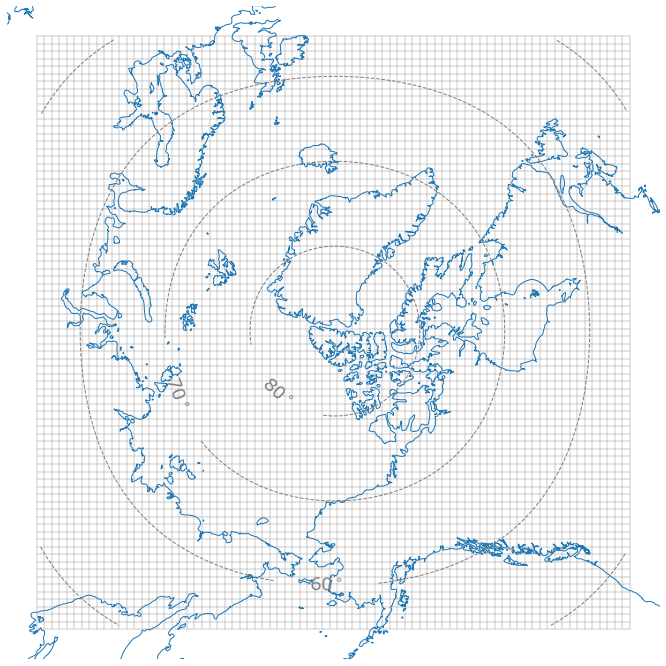

In [3]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set_axis_off()
ax.set_aspect('equal')

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color='grey', linewidth=.4)
xlim, ylim = ax.get_xlim(), ax.get_ylim()

# coastlines 
cd = Dipole(time.year) # geo to centered dipole
for cl in grid.projection.get_projected_coastlines():
    lon, lat = grid.projection.cube2geo(cl[0], cl[1])
    mlat, mlon = cd.geo2mag(lat, lon)
    xis, etas = grid.projection.geo2cube(mlon, mlat)
    ax.plot(xis, etas, color='C0', linewidth=1)

# add magnetic latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles='--', colors='grey', linewidths=1, levels=np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 18, fmt='%1.0f$^\circ$')

ax.set_xlim(xlim)
ax.set_ylim(ylim);

#### Ionospheric conductances

A Lompe `Emodel` object requires functions for ionospheric conductances when initialized. We use the `hardy_EUV()` conductance function (see Notebook 03 for more details). We specify `dipole=True` to indicate that the latitudes and longitudes used as input are in centered dipole coordinates.

In [4]:
Kp   = 4                        # for Hardy model
F107 = 100                      # sfu, for EUV conductance

# functions for conductances to be passed to the Lompe model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'hall',     dipole=True)
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'pedersen', dipole=True)

#### Input data - FAC densities from the AMPS model

We want to use FAC densities as input to the Lompe model. We use the Average Magnetic field and Polar current System [(AMPS) model](https://birkeland.uib.no/data/amps/) described in [Laundal et al. (2018)](https://doi.org/10.1029/2018JA025387), to obtain synthetic data. The [`pyAMPS`](https://github.com/klaundal/pyAMPS/) module gives empirical patterns for ionospheric currents for a given solar wind veolcity, IMF B$_y$ and B$_z$, dipole tilt angle, and F 10.7 index. Here, we set the solar wind velocity to 350 km/s, IMF B$_y=0$ nT, IMF B$_z=-4$ nT, dipole tilt 25$^\circ$, and the F10.7 index is set to 100. Note that [`pyAMPS`](https://github.com/klaundal/pyAMPS/) requires coordinates to be given in magnetic latitude and local time (MLT) when obtaining the FAC density.

In [5]:
from pyamps import AMPS
# get AMPS model
m = AMPS(350, # Solar wind velocity in km/s
           0, # IMF By (GSM) in nT
          -4, # IMF Bz (GSM) in nT,
          25, # dipole tilt angle in degrees
         100, # F10.7 index
   minlat=50) # minimum latitude

# get FAC from AMPS model
mlt = cd.mlon2mlt(grid.lon, time)
AMPSfac = m.get_upward_current(grid.lat, mlt) * 1e-6 # to Ampere per square meter

Input data for Lompe of the `fac` datatype needs to be defined on the entire `CSgrid` (*grid_J*; [Laundal et al., 2022.](https://doi.org/10.1029/2022JA030356)). In the above cell, the FAC desnities from `pyAMPS` were obtained for all grid cell cooridnates, and thus defined on the whole grid.

In [6]:
# field-aligned current
FACdata = lompe.Data(AMPSfac.flatten(), np.vstack((grid.lon.flatten(), grid.lat.flatten())), datatype='fac')

/Users/laundal/BCSS-DAG Dropbox/Karl Laundal/git/installable/lompe/lompe/model/data.py:144: UserWarning: 'error' keyword not set for datatype 'fac'! Using error=1e-06
  warnings.warn(f"'error' keyword not set for datatype '{datatype}'! Using error={error}", UserWarning)
/Users/laundal/BCSS-DAG Dropbox/Karl Laundal/git/installable/lompe/lompe/model/data.py:148: UserWarning: 'iweight' keyword not set for datatype 'fac'! Using iweight=1.0
  warnings.warn(f"'iweight' keyword not set for datatype '{datatype}'! Using iweight={iweight}", UserWarning)
/Users/laundal/BCSS-DAG Dropbox/Karl Laundal/git/installable/lompe/lompe/model/data.py:156: UserWarning: Warning: FAC data must be defined on the whole Emodel.grid_J, but this is not checked.
  warnings.warn('Warning: FAC data must be defined on the whole Emodel.grid_J, but this is not checked.', UserWarning)


#### The Lompe model vector
Now, we can initialize a Lompe `Emodel` object, add the input data, and run the inversion to get the model vector, $\mathrm{\underline{m}}$, that can be used to obtain other ionospheric parameters in the region. An explanation of the inversion technique and regularization parameters can be found in Section 3.3 of [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356).

See Notebook 07, or notebooks in */lompe_paper_figures/* for more lompe examples.

Since we define our grid in centered dipole coordinates, we set `dipole=True` when initializing the model. Lompe wll then use dipole magnetic field instead of IGRF to define the magnetic eastward direction, and all coordinates are assumed to be dipole coordinates.

In [7]:
# initialize model
model = lompe.Emodel(grid, Hall_Pedersen_conductance=(SH, SP), dipole=True)

# add input data
model.add_data(FACdata)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1=0.02, l2=0.01);

#### Plot and save

We use `lompeplot` to show all ionospheric parameters that we can obtain with this input data. In Notebook 07, we show how to obtain arrays containing the model predictions for individual ionospheric parameters for any location within the analysis region.

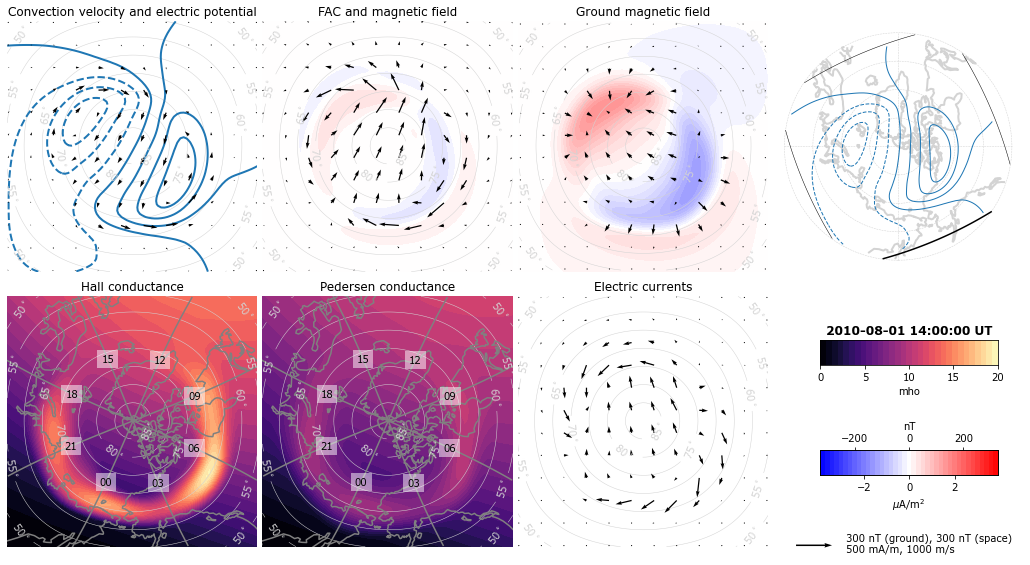

In [8]:
fig = lompe.lompeplot(model, include_data=False, apex=apexpy.Apex(time), time=time, savekw={'fname':'./output_figures/08LompeforMIcoupling.pdf'})
# also save png
fig.savefig('./output_figures/08LompeforMIcoupling.png')

The top row shows, from left to right: 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere (110 km above grid altitude) as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales

If the `include_data` keyword is set to `True`, orange vectors are used to show the input data in their respective panels. This is not done here, as the input data is defined on the entire grid, and is vertical.